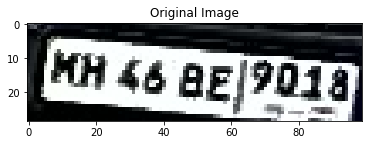

In [2]:
# -*- coding: utf-8 -*-
"""Deskew_correction_updated.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1SuMfmaXohIJy21jL13AplE4_GkcwBkrG
"""

#To access gdrive files in google colab

#%cd ..
#from google.colab import drive
#drive.mount('/content/gdrive')

# Commented out IPython magic to ensure Python compatibility.
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
# %matplotlib inline
from PIL import Image

#reading and displaying of image
image = cv2.imread('4T.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converted to rgb to get corrected image even after reading it directly
plt.imshow(image)
plt.title('Original Image')
plt.show()

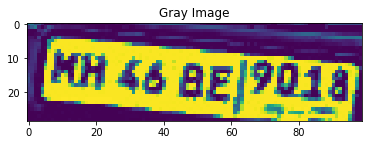

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #to get gray scale image
kernel = np.ones((5, 5), np.float32) / 15
#filtered = cv2.filter2D(gray, -1, kernel) #Blurred image
plt.imshow(gray)
plt.title('Gray Image')
plt.show()

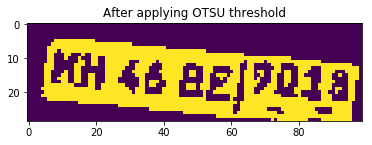

In [7]:
# Otsu Threshold for binary classification of the image; i.e. classify each pixel as either black or white.
ret, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_OTSU) 
plt.title('After applying OTSU threshold')
plt.imshow(thresh)
plt.show()

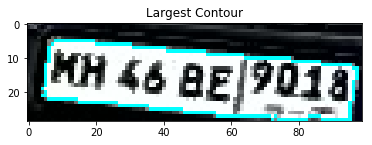

In [9]:
image_copy = image.copy() #copy of original image

# Contour Detection
_,contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0] 
cv2.drawContours(image_copy, cnt, -1, (0, 255, 255), 1)
plt.title('Largest Contour')
plt.imshow(image_copy)
plt.show()

In [10]:

#epsilon detect curved parts in an image 
#cv2.approxPolyDP() uses Douglas-Peucker algorithm to approximate a curve or a polygon with fewer vertices 
#so that the distance between them is less than epsilon. (to get good approximation of contour)
epsilon = 0.02 * cv2.arcLength(cnt, True) #2% of the contour arc length
approx_corners = cv2.approxPolyDP(cnt, epsilon, True) #corner detection
#approx_corners = np.concatenate(approx_corners).tolist()
cv2.drawContours(image_copy, approx_corners, -1, (255, 255, 0), 5)
approx_corners = np.concatenate(approx_corners).tolist() 
print(approx_corners)

[[6, 7], [6, 22], [95, 28], [95, 12]]


In [12]:
import math

# Input points from approx poly
#pts = [(10,20),(120,22),(300,18),(310,100),(150,100),(8,95)]
pts = approx_corners
print("input points" , pts)

def distance(pt1,pt2):
    return math.sqrt( (pt2[0]-pt1[0])*(pt2[0]-pt1[0]) + (pt2[1]-pt1[1])*(pt2[1]-pt1[1]) )


# width and height of cropped image
w = 300
h = 100

#starting edge points as centre
top_left_pt = (w/2,h/2)
top_right_pt = (w/2,h/2)
bottom_right_pt = (w/2,h/2)
botton_left_pt = (w/2,h/2)

#assign highest dimension width or height ( Mostly width)
d_tl = w
d_tr = w
d_bl = w
d_br = w

for pt in pts:
    temp_d_tl = distance(pt,(0,0))
    temp_d_tr = distance(pt,(w,0))
    temp_d_bl = distance(pt,(0,h))
    temp_d_br = distance(pt,(w,h))
    
    # compare the points against edge points to get edge points
    if( temp_d_tl < d_tl ):
        d_tl = temp_d_tl
        top_left_pt = pt

    if( temp_d_tr < d_tr ):
        d_tr = temp_d_tr
        top_right_pt = pt
    
    if( temp_d_bl < d_bl ):
        d_bl = temp_d_bl
        botton_left_pt = pt
    
    if( temp_d_br < d_br ):
        d_br = temp_d_br
        bottom_right_pt = pt

Edge_points = [top_left_pt,top_right_pt,bottom_right_pt,botton_left_pt]
# Edge_points = [top_left_pt,botton_left_pt,bottom_right_pt,top_right_pt]
print("Edge Points",Edge_points)

input points [[6, 7], [6, 22], [95, 28], [95, 12]]
Edge Points [[6, 7], [95, 12], [95, 28], [6, 22]]


In [13]:
print('\nThe corner points are ...\n')
for index, c in enumerate(Edge_points):
        character = chr(65 + index)
        print(character, ':', c)
        cv2.putText(image_copy, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)



The corner points are ...

A : [6, 7]
B : [95, 12]
C : [95, 28]
D : [6, 22]


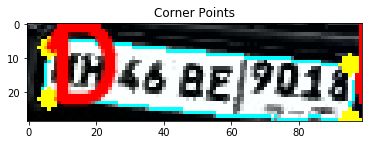

In [14]:
approx_corners = Edge_points
plt.imshow(image_copy)
plt.title('Corner Points')
plt.show()

In [20]:
w1 = np.sqrt((approx_corners[0][0] - approx_corners[1][0]) ** 2 + (approx_corners[0][1] - approx_corners[1][1]) ** 2)
w2 = np.sqrt((approx_corners[2][0] - approx_corners[3][0]) ** 2 + (approx_corners[2][1] - approx_corners[3][1]) ** 2)
w = max(int(w1), int(w2))

#h1 = np.sqrt((Edge_points[0][0] - Edge_points[2][0]) ** 2 + (Edge_points[0][1] - Edge_points[2][1]) ** 2)
#h2 = np.sqrt((Edge_points[1][0] - Edge_points[3][0]) ** 2 + (Edge_points[1][1] - Edge_points[3][1]) ** 2)
#h = max(int(h1), int(h2))

h1 = np.sqrt((approx_corners[0][0] - approx_corners[3][0]) ** 2 + (approx_corners[0][1] - approx_corners[3][1]) ** 2)
h2 = np.sqrt((approx_corners[1][0] - approx_corners[2][0]) ** 2 + (approx_corners[1][1] - approx_corners[2][1]) ** 2)
h = max(int(h1), int(h2))

In [21]:
destination_corners = np.float32([(0, 0), (w - 1, 0), (w - 1, h - 1), (0, h - 1)])#no flipping and rotation require


In [22]:
print(approx_corners)
print(destination_corners)

[[6, 7], [95, 12], [95, 28], [6, 22]]
[[ 0.  0.]
 [88.  0.]
 [88. 15.]
 [ 0. 15.]]


In [23]:
print(w,h)

89 16


In [24]:

print('\nThe destination points are: \n')
for index, c in enumerate(destination_corners):
    character = chr(65 + index) + "'"
    print(character, ':', c)
        
    print('\nThe approximated height and width of the original image is: \n', (h, w))
    


The destination points are: 

A' : [0. 0.]

The approximated height and width of the original image is: 
 (16, 89)
B' : [88.  0.]

The approximated height and width of the original image is: 
 (16, 89)
C' : [88. 15.]

The approximated height and width of the original image is: 
 (16, 89)
D' : [ 0. 15.]

The approximated height and width of the original image is: 
 (16, 89)



The homography matrix is: 
 [[ 1.05944319e+00  4.15568187e-17 -6.35665914e+00]
 [-5.64334086e-02  1.00451467e+00 -6.69300226e+00]
 [ 7.52445448e-04  1.68703484e-18  1.00000000e+00]]


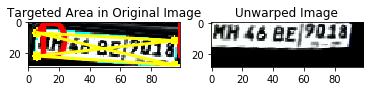

In [25]:
h, w = image.shape[:2] #height and width of original image

#RANSAC algorithm used for matrix calculation
H, _ = cv2.findHomography(np.float32(approx_corners), destination_corners, method=cv2.RANSAC, ransacReprojThreshold=3.0)
print('\nThe homography matrix is: \n', H)
un_warped = cv2.warpPerspective(image, H, (w, h), flags=cv2.INTER_LINEAR)

# plot

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(image_copy)
#x = [Edge_points[0][0], Edge_points[2][0], Edge_points[3][0], Edge_points[1][0], Edge_points[0][0]]
#y = [Edge_points[0][1], Edge_points[2][1], Edge_points[3][1], Edge_points[1][1], Edge_points[0][1]]

x = [approx_corners[0][0], approx_corners[2][0], approx_corners[3][0], approx_corners[1][0], approx_corners[0][0]]
y = [approx_corners[0][1], approx_corners[2][1], approx_corners[3][1], approx_corners[1][1], approx_corners[0][1]]

#x = [approx_corners[0][0], approx_corners[1][0], approx_corners[2][0], approx_corners[3][0], approx_corners[0][0]] 
#y = [approx_corners[0][1], approx_corners[1][1], approx_corners[2][1], approx_corners[3][1], approx_corners[0][1]]
ax1.plot(x, y, color='yellow', linewidth=3)
ax1.set_ylim([h, 0])
ax1.set_xlim([0, w])
ax1.set_title('Targeted Area in Original Image')
ax2.imshow(un_warped)
ax2.set_title('Unwarped Image')
plt.show()